# Task 2

## Contents

1. [Problem Statement](#problem-statement)
2. [Implementation](#implementation)
3. [Noise Model for the arbitrary error gates](#noise-model)
4. [Circuit Layout without error correction code](#circuit-error)
    - [Noise Channel](#noise-channel1)
    - [Observation](#observation1)
5. [Circuit Layout with error correction code](#circuit-shor)
    - [Shor code](#shor)
        - [Reason for using the Shor code](#reason)
        - [Introduction](#introduction)
    - [Shor Code Implementation](#shor-imp)
        - [Encoding](#encoding)
        - [Noise Channel](#noise-channel2)
        - [Decoding](#decoding)
        - [Observation](#observation2)
6. [Conclusion](#conclusion)
7. [References](#references)

<a id='problem-statement'></a>
## Problem Statement -

1. Build the following simple circuit to prepare the Bell state: 
![Bell State](BellState.png "Bell State")
2. Now add, right before the CNOT gate and for each of the two qubits, an arbitrary “error gate”. By error gate we mean that with a certain probability (that you can decide but must be non-zero for all the choices) you have a 1 qubit unitary which can be either the identity, or the X gate (bit-flip error) or the Z gate (sign-flip error).
3. Encode each of the two qubits with a sign-flip or a bit-flip code, in such a way that all the possible choices for the error gates described in 2., occurring on the logical qubits, can be detected and fixed. Motivate your choice. This is the most non-trivial part of the problem, so do it with a lot of care!
4. Test your solution by making many measurements over the final state and testing that the results are in line with the expectations.

<a id='implementation'></a>
## Implementation

In this project, I used qiskit to implement the circuit.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.visualization import plot_histogram
%matplotlib inline

<a id='noise-model'></a>
## Noise Model for the arbitrary error gates

**pauli_error** function from qiskit used to generate bit flip operator with **p_error** error. Then Noise is generated using **NoiseModel** from qiskit.

In [2]:
p_error = 0.05
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(bit_flip, ["id"])

<a id='circuit-error'></a>
## Circuit Layout without error correction code

In [3]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
circuit = QuantumCircuit(qr, cr)

# For qr0
circuit.h(qr[0])

In [4]:
circuit.barrier(qr)

<a id='noise-channel1'></a>
### Noise Channel

In [5]:
circuit.id(qr[0])
circuit.id(qr[1])

In [6]:
circuit.barrier(qr)

In [7]:
circuit.cx(qr[0], qr[1])
circuit.measure(qr,cr)

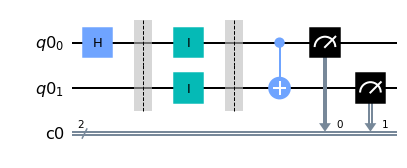

In [8]:
circuit.draw(output = 'mpl')

In [9]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend = simulator, noise_model=noise_model, shots=2000).result()

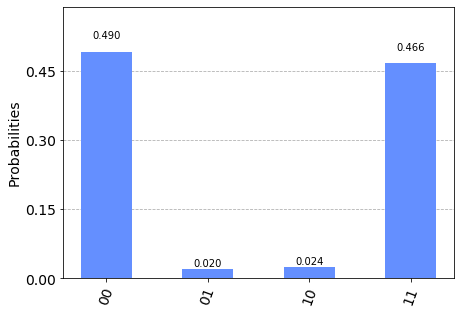

In [10]:
plot_histogram(result.get_counts(circuit))

In [11]:
noisy_counts = result.get_counts()

print("\nBefore applying Shor code ")
print("--------------------------------------")
print(noisy_counts)


Before applying Shor code 
--------------------------------------
{'00': 981, '01': 40, '10': 48, '11': 931}


<a id='observation1'></a>
### Observation

As we can observe approx. 5% of the 2000 shots are distributed between 01 and 10 states. It's because the [noise channel](#noise-channel1) either bit flips the state of the qubit, with probability 0.05 or leaves it unchanged.

<a id='circuit-shor'></a>
## Circuit Layout with error correction code

In [12]:
qr = QuantumRegister(18)
cr = ClassicalRegister(2)
circuit = QuantumCircuit(qr, cr)

# For qr0
circuit.h(qr[0])

In [13]:
circuit.barrier(qr)

<a id='shor'></a>
### Shor code
<a id='reason'></a>
#### Reason for using the Shor code

In the third point of the [problem statement](#problem-statement) it is mentioned that *the two qubits has to be encoded in such a way that **all the possible choices** for the error gates described in the second point can be detected and fixed*. Since the Shor code is a combination of bit flip and phase flip codes, so its a perfert choice to detect and fix all the possible choices for the error gates.
<a id='introduction'></a>
#### Introduction

The Shor code is a 9 qubit circuit that requires 8 ancillary qubits to correct 1 qubit. 

Essentially, the Shor code is a combination of bit flip and phase flip codes. We first encode a qubit using the encoding procedure of the phase flip code: $\left|0\right\rangle → \left|+ + +\right\rangle, \left|1\right\rangle → \left|− − −\right\rangle$. This is followed by encoding each of these 3 qubits according to the bit flip encoding procedure:
$$\left|+\right\rangle → \frac{1}{\sqrt{2}}\big[\left|000\right\rangle + \left|111\right\rangle\big]$$
$$\left|-\right\rangle → \frac{1}{\sqrt{2}}\big[\left|000\right\rangle - \left|111\right\rangle\big]$$

Thus the final codewords are:
$$\left|0\right\rangle → \left|0_{L}\right\rangle = \frac{1}{2\sqrt{2}}\big[\left|000\right\rangle + \left|111\right\rangle\big]\big[\left|000\right\rangle + \left|111\right\rangle\big]\big[\left|000\right\rangle + \left|111\right\rangle\big]$$
$$\left|0\right\rangle → \left|0_{L}\right\rangle = \frac{1}{2\sqrt{2}}\big[\left|000\right\rangle - \left|111\right\rangle\big]\big[\left|000\right\rangle - \left|111\right\rangle\big]\big[\left|000\right\rangle - \left|111\right\rangle\big]$$

To show that the Shor code can correct any quantum error on a single qubit, we first show that it detects and corrects the following errors :-

- Bit flip error on a single qubit.
- Phase flip error on a single qubit.
- Combined bit and phase flip error on a single qubit.

![Shor Code](ShorCode.png "Shor Code")

The 1st, 4th and 7th qubits are for the sign flip code, while the three group of qubits $(1,2,3), (4,5,6),$ and $(7,8,9)$ are designed for the bit flip code. 

If a bit flip error happens to a qubit, the syndrome analysis will be performed on each set of states $(1,2,3), (4,5,6),$ and $(7,8,9),$ then correct the error.

If the three bit flip group $(1,2,3), (4,5,6),$ and $(7,8,9)$ are considered as three inputs, then the Shor code circuit can be reduced as a sign flip code. This means that the Shor code can also repair sign flip error for a single qubit.

The Shor code also can correct for any arbitrary errors (both bit flip and sign flip) to a single qubit. If an error is modeled by a unitary transform U, which will act on a qubit $\left|\psi\right\rangle$ , then $U$ can be described in the form

$$U=c_{0}I+c_{1}\sigma _{x}+c_{2}\sigma _{y}+c_{3}\sigma _{z}$$

where $c_{0}, c_{1}, c_{2},$ and $c_{3}$ are complex constants, I is the identity, and the Pauli matrices are given by

$$\sigma _{x}={\biggl (}{\begin{matrix}0&1\\1&0\end{matrix}}{\biggr )};
\sigma _{y}={\biggl (}{\begin{matrix}0&-i\\i&0\end{matrix}}{\biggr )};
\sigma _{z}={\biggl (}{\begin{matrix}1&0\\0&-1\end{matrix}}{\biggr )}$$

As per the problem statement we have a Bell State, and an arbitrary “error gate” is added right before the CNOT gate and for each of the two qubits. Therefore to detect and fix the error we have taken 18 qubits to encode 2 qubits (qr0 and qr9, which are in Bell State)
<a id='shor-imp'></a>
### Shor Code Implementation
<a id='encoding'></a>
#### Encoding

The Shor code works by first taking the computational state of the main qubit and transferring it to two other qubits, let's call them target qubit (For qr0 it's qr3 and qr6, and for it's qr12 and qr15 ). These qubits are used for correcting phase errors.

In [14]:
# For qr0
circuit.cx(qr[0],qr[3])
circuit.cx(qr[0],qr[6])
# For qr9
circuit.cx(qr[9],qr[12])
circuit.cx(qr[9],qr[15])

After this these qubits are put in to superposition using a Hadamard gate.

In [15]:
# For qr0
circuit.h(qr[0])
circuit.h(qr[3])
circuit.h(qr[6])
# For qr9
circuit.h(qr[9])
circuit.h(qr[12])
circuit.h(qr[15])

Next the states of the main qubits (qr0, qr9) as well as the target qubits (qr3, qr6, qr12, qr15) use CNOT gates to transfer their states to ancillary qubits responsible for correcting bit flips.

In [16]:
# For qr0
circuit.cx(qr[0],qr[1])
circuit.cx(qr[0],qr[2])
# For qr9
circuit.cx(qr[9],qr[10])
circuit.cx(qr[9],qr[11])

In [17]:
# For qr0
circuit.cx(qr[3],qr[4])
circuit.cx(qr[3],qr[5])
# For qr9
circuit.cx(qr[12],qr[13])
circuit.cx(qr[12],qr[14])

In [18]:
# For qr0
circuit.cx(qr[6],qr[7])
circuit.cx(qr[6],qr[8])
# For qr9
circuit.cx(qr[15],qr[16])
circuit.cx(qr[15],qr[17])

In [19]:
circuit.barrier(qr)

<a id='noise-channel2'></a>
#### Noise Channel

After this a bit flip or phase flip (it this case we have taken bit flip error) will occur with a certain probalility on the main qubits (qr0, qr9). Noise Model has been created [before](#noise-model).

In [20]:
circuit.id(qr[0])
circuit.id(qr[9])

In [21]:
circuit.barrier(qr)

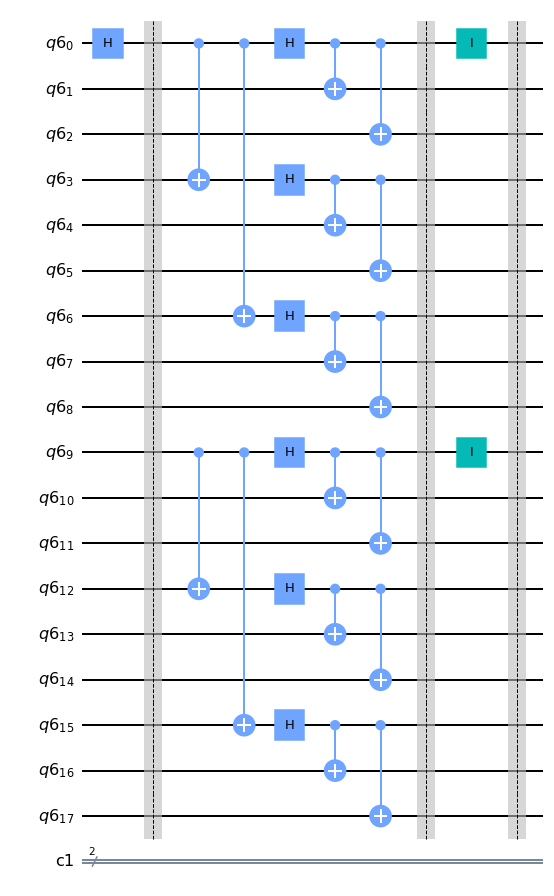

In [22]:
circuit.draw(output='mpl')

<a id='decoding'></a>
#### Decoding

Next the previous step is repeated. Toffoli gates are then applied to the main qubits as well as the target qubits where the control qubits are the auxiliary qubits responsible for phase correction.

In [23]:
# For qr0
circuit.cx(qr[0],qr[1])
circuit.cx(qr[0],qr[2])
# For qr9
circuit.cx(qr[9],qr[10])
circuit.cx(qr[9],qr[11])

In [24]:
# For qr0
circuit.cx(qr[3],qr[4])
circuit.cx(qr[3],qr[5])
# For qr9
circuit.cx(qr[12],qr[13])
circuit.cx(qr[12],qr[14])

In [25]:
# For qr0
circuit.cx(qr[6],qr[7])
circuit.cx(qr[6],qr[8])
# For qr9
circuit.cx(qr[15],qr[16])
circuit.cx(qr[15],qr[17])

In [26]:
# For qr0
circuit.ccx(qr[2],qr[1],qr[0])
circuit.ccx(qr[5],qr[4],qr[3])
circuit.ccx(qr[8],qr[7],qr[6])
# For qr9
circuit.ccx(qr[11],qr[10],qr[9])
circuit.ccx(qr[14],qr[13],qr[12])
circuit.ccx(qr[17],qr[16],qr[15])

After this Hadamard gates are applied to the main qubits as well as the target qubits to bring them out of superposition.

In [27]:
# For qr0
circuit.h(qr[0])
circuit.h(qr[3])
circuit.h(qr[6])
# For qr9
circuit.h(qr[9])
circuit.h(qr[12])
circuit.h(qr[15])

Then CNOT gates are applied to the target qubits where the control qubits are the main qubits.

In [28]:
# For qr0
circuit.cx(qr[0],qr[3])
circuit.cx(qr[0],qr[6])
# For qr9
circuit.cx(qr[9],qr[12])
circuit.cx(qr[9],qr[15])

Finally a toffoli gate is applied to the main qubits which are controlled by the target qubits. 

In [29]:
# For qr0
circuit.ccx(qr[6],qr[3],qr[0])
# For qr9
circuit.ccx(qr[15],qr[12],qr[9])

In [30]:
circuit.barrier(qr)

In [31]:
circuit.cx(qr[0], qr[9])
circuit.measure([qr[0],qr[9]],cr)

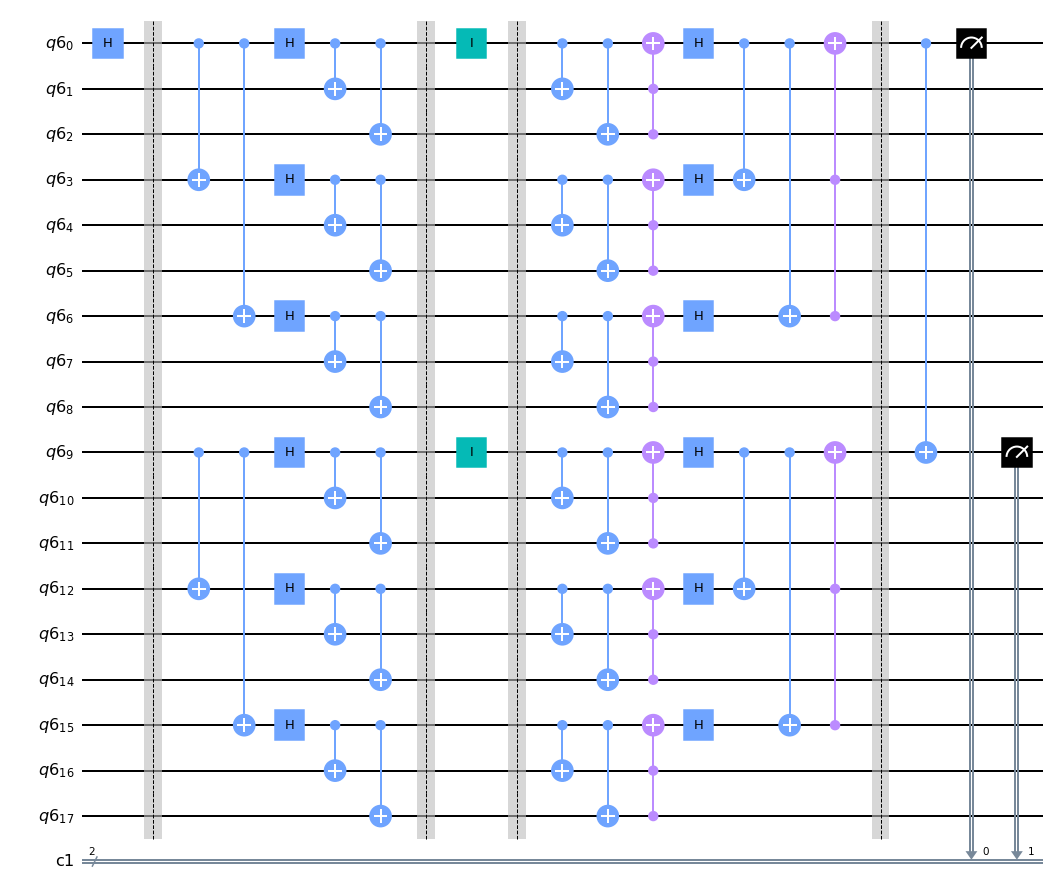

In [32]:
circuit.draw(output = 'mpl')

In [33]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend = simulator, noise_model=noise_model, shots=2000).result()

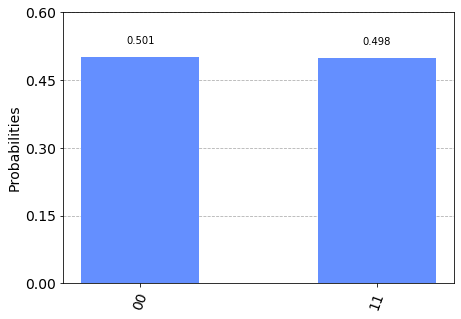

In [34]:
plot_histogram(result.get_counts(circuit))

In [35]:
corrected_counts = result.get_counts()

print("\nAfter applying Shor code")
print("--------------------------------------")
print(corrected_counts)


After applying Shor code
--------------------------------------
{'00': 1003, '11': 997}


<a id='observation2'></a>
### Observation

As we can see the errors has been corrected and the  qubits (qr0 and qr9 in this case) are perfectly entangled.

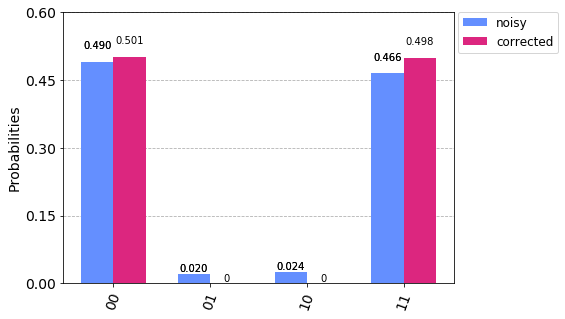

In [36]:
plot_histogram([noisy_counts, corrected_counts], legend=['noisy', 'corrected'])

<a id='conclusion'></a>
## Conclusion

Quantum error correction code is a vital part of the quantum computing pipeline. The noise generated in this task can be a combination of bit flip and phase flip errors. To detect and correct the noise generated, the shor code was used. It's a combination of bit flip and phase flip code. The shor code is not very efficient with respect to the time complexity and number of gates. But it works fine as per the problem statement. Quantum error correction is only one part of a much-needed effort to make effecient quantum computer, but it is an important part that can help make a big difference.


<a id='references'></a>
## References

- https://en.wikipedia.org/wiki/Quantum_error_correction
- https://www.cs.umd.edu/class/fall2018/cmsc657/projects/group_4.pdf
- https://www.cse.iitk.ac.in/users/amitks/quantum/report_pranav_samik.pdf
- https://qiskit.org/documentation/tutorials/simulators/3_building_noise_models.html
- https://qiskit.org/documentation/stubs/qiskit.providers.aer.noise.pauli_error.html
- https://quantumcomputinguk.org/tutorials/quantum-error-correction-shor-code-in-qiskit